# Example Use Cases

In [1]:
import numpy as np
import hopsy
import x3cfluxpy as x3c

/home/rpaul/.miniconda3/lib/python3.9/site-packages/PolyRound/settings.py:55: UserWarning: hp_flag OptimalityTol not supported by backend glpk passed
  warnings.warn(


## 1. Uniform & Truncated Gaussian Polytope Sampling

In [2]:
#coryne = 

SyntaxError: invalid syntax (2378014060.py, line 1)

## 2. Bioprocess Modelling

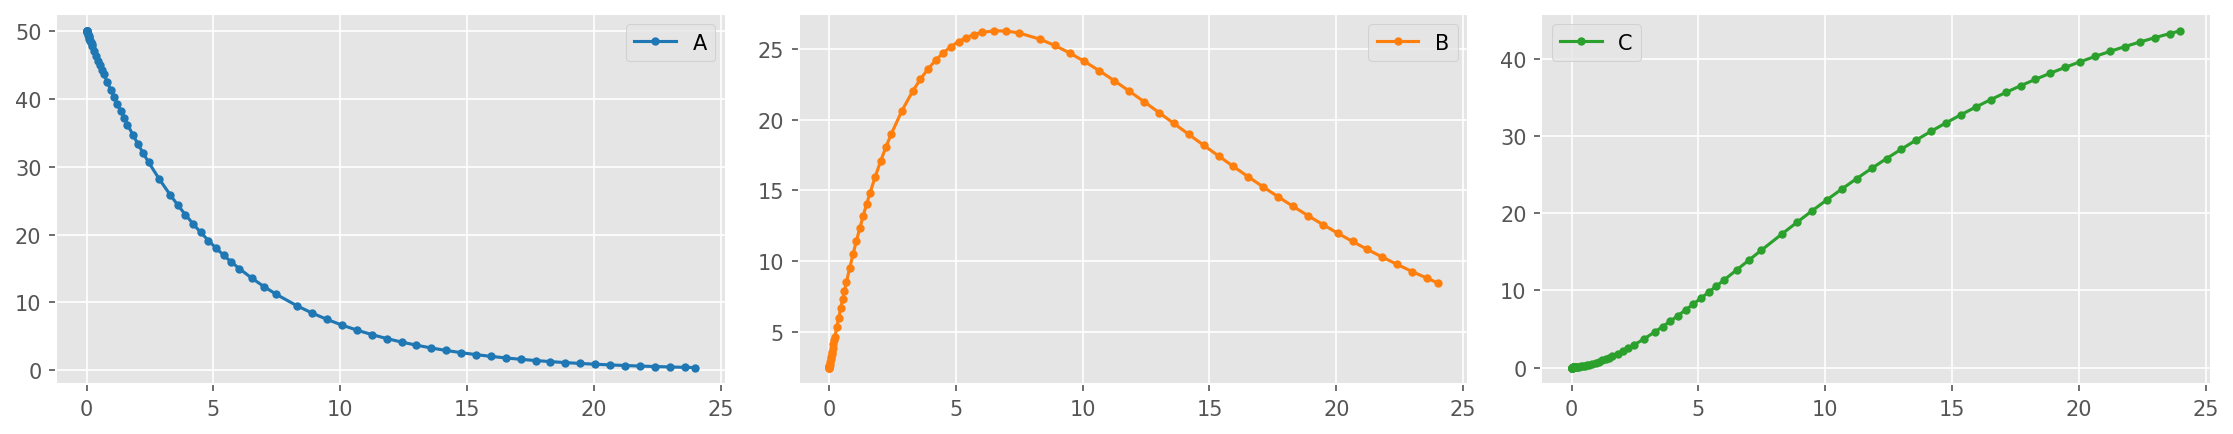

In [16]:
from pyfoomb import BioprocessModel, ObservationFunction, Caretaker, Visualization, Measurement, LossCalculator

# Defines the model class
class SequentialKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        k2 = self.model_parameters['k2']
        
        # Defines the derivatives.
        dAdt = -k1 * A
        dBdt = k1 * A - k2*B
        dCdt = k2*B
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 2.5,
    'C0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
}

# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

_ = Visualization.show_kinetic_data(simulation)

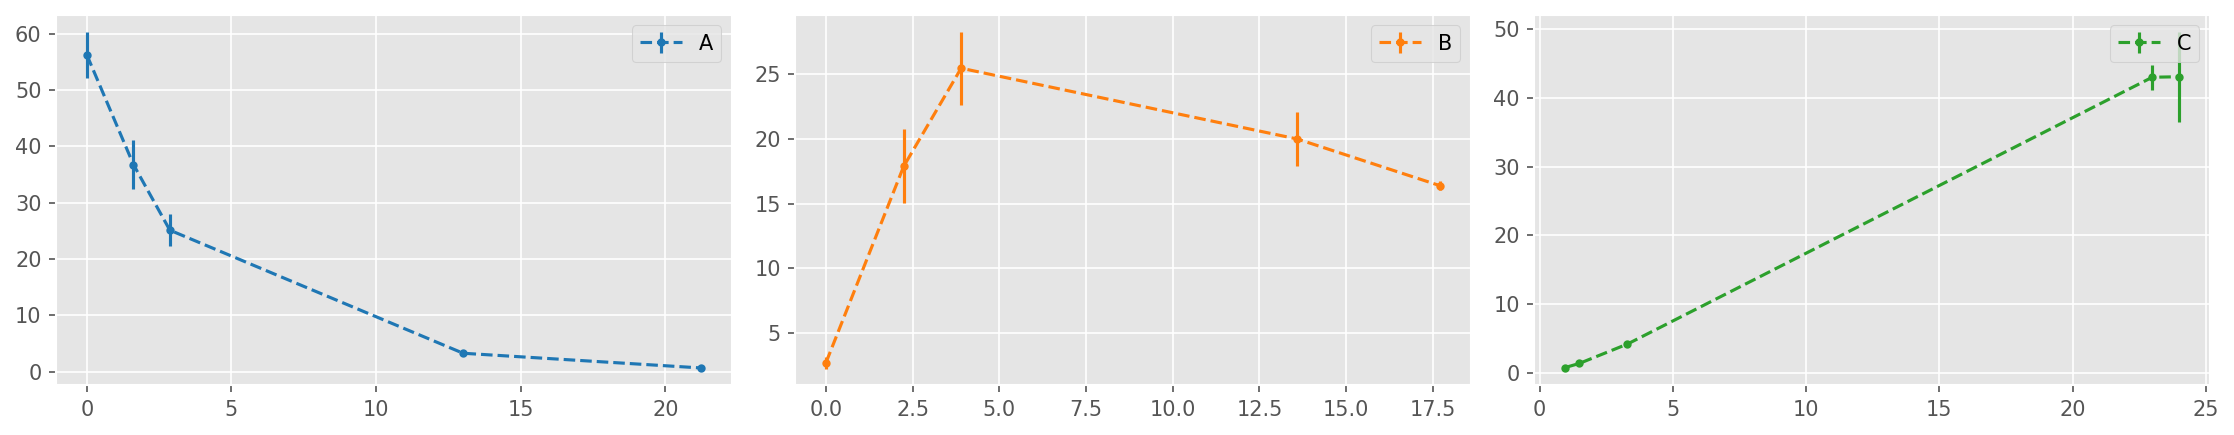

In [20]:
# Defines a helper method that creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
        artifical_data = []
        for simulation in simulations:
            _name = simulation.name
            _replicate_id = simulation.replicate_id
            _timepoints = simulation.timepoints
            _values = simulation.values
            _rnd_values = [
                np.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
                for _ in range(repetitions)
            ]
            _values = np.mean(_rnd_values, axis=0)
            _errors = np.std(_rnd_values, ddof=1, axis=0)
            selector = np.sort(
                np.random.choice(range(len(_timepoints)), size=samples, replace=False),
            )
            if with_errors:
                artifical_data.append(
                    Measurement(name=_name, timepoints=_timepoints[selector], values=_values[selector], 
                                errors=_errors[selector], replicate_id=_replicate_id),
                )
            else:
                artifical_data.append(
                    Measurement(name=_name, timepoints=_timepoints[selector], values=_values[selector], 
                                replicate_id=_replicate_id),
                )
        return artifical_data

# Create the noisy data
data = noisy_samples(simulation, rel_err=.1)
    
# Visualize the noisy data
_ = Visualization.show_kinetic_data(data)

In [32]:
unknowns = ['k1', 'k2', 'B0']
bounds = [(0, 100), (0, 100), (0, 50)]

ground_truth = [(initial_values | model_parameters)[unknown] for unknown in unknowns]

est, est_info = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data, 
    report_level=0,
)

estimate = [est[key] for key in unknowns]

loss = LossCalculator(unknowns=unknowns, bounds=bounds, measurements=data, caretaker_loss_fun=caretaker.loss_function, metric="negLL")

class KineticModel():
    def __init__(self, loss):#, ciso_model):
        self._loss = loss
        #self._ciso_model = ciso_model
        self._A = np.vstack([np.eye(len(loss.upper_bounds)), -np.eye(len(loss.lower_bounds))])
        self._b = np.hstack([np.array(loss.upper_bounds), np.array(loss.lower_bounds)])
        
    @property
    def A(self):
        return self._A
        
    @property
    def b(self):
        return self._b
        
    def compute_negative_log_likelihood(self, x):
        return loss.fitness(x)[0]# + ciso_model.compute_negative_log_likelihood(x)
    
        
model = KineticModel(loss)
problem = hopsy.Problem(model.A, model.b, model)

#problem = hopsy.round(problem)

seed = 0
n_chains = 4

chains = [hopsy.MarkovChain(hopsy.DikinWalkProposal(problem, starting_point=estimate), problem) for i in range(n_chains)]
rngs = [hopsy.RandomNumberGenerator(seed, i) for i in range(n_chains)]

for chain in chains:
    chain.proposal.stepsize = 0.01

# heavy-duty
#start = time.time()
accrates, states = hopsy.sample(chains, rngs, 10_000, n_threads=4)
#print(time.time() - start, "elapsed")

[[1.00115985 1.00078432 1.00570061]] [[0.08205441 0.06149575 0.0079529 ]]


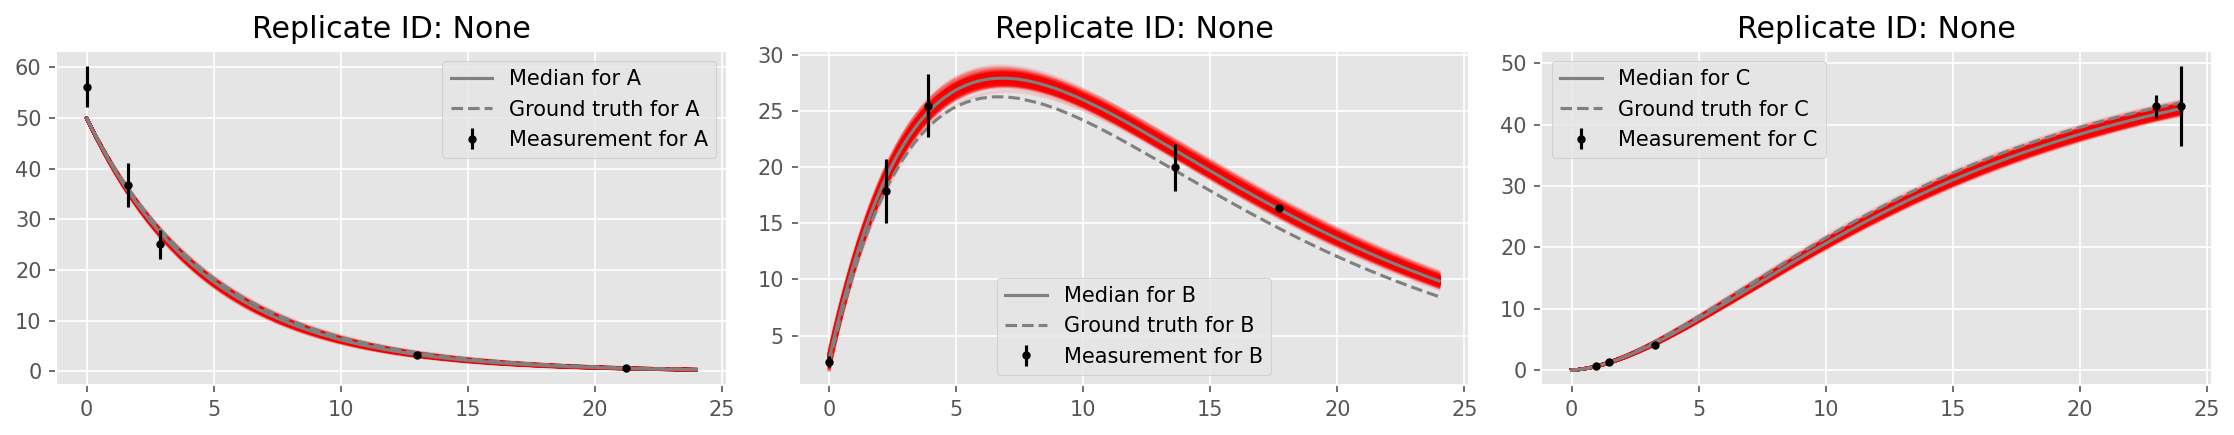

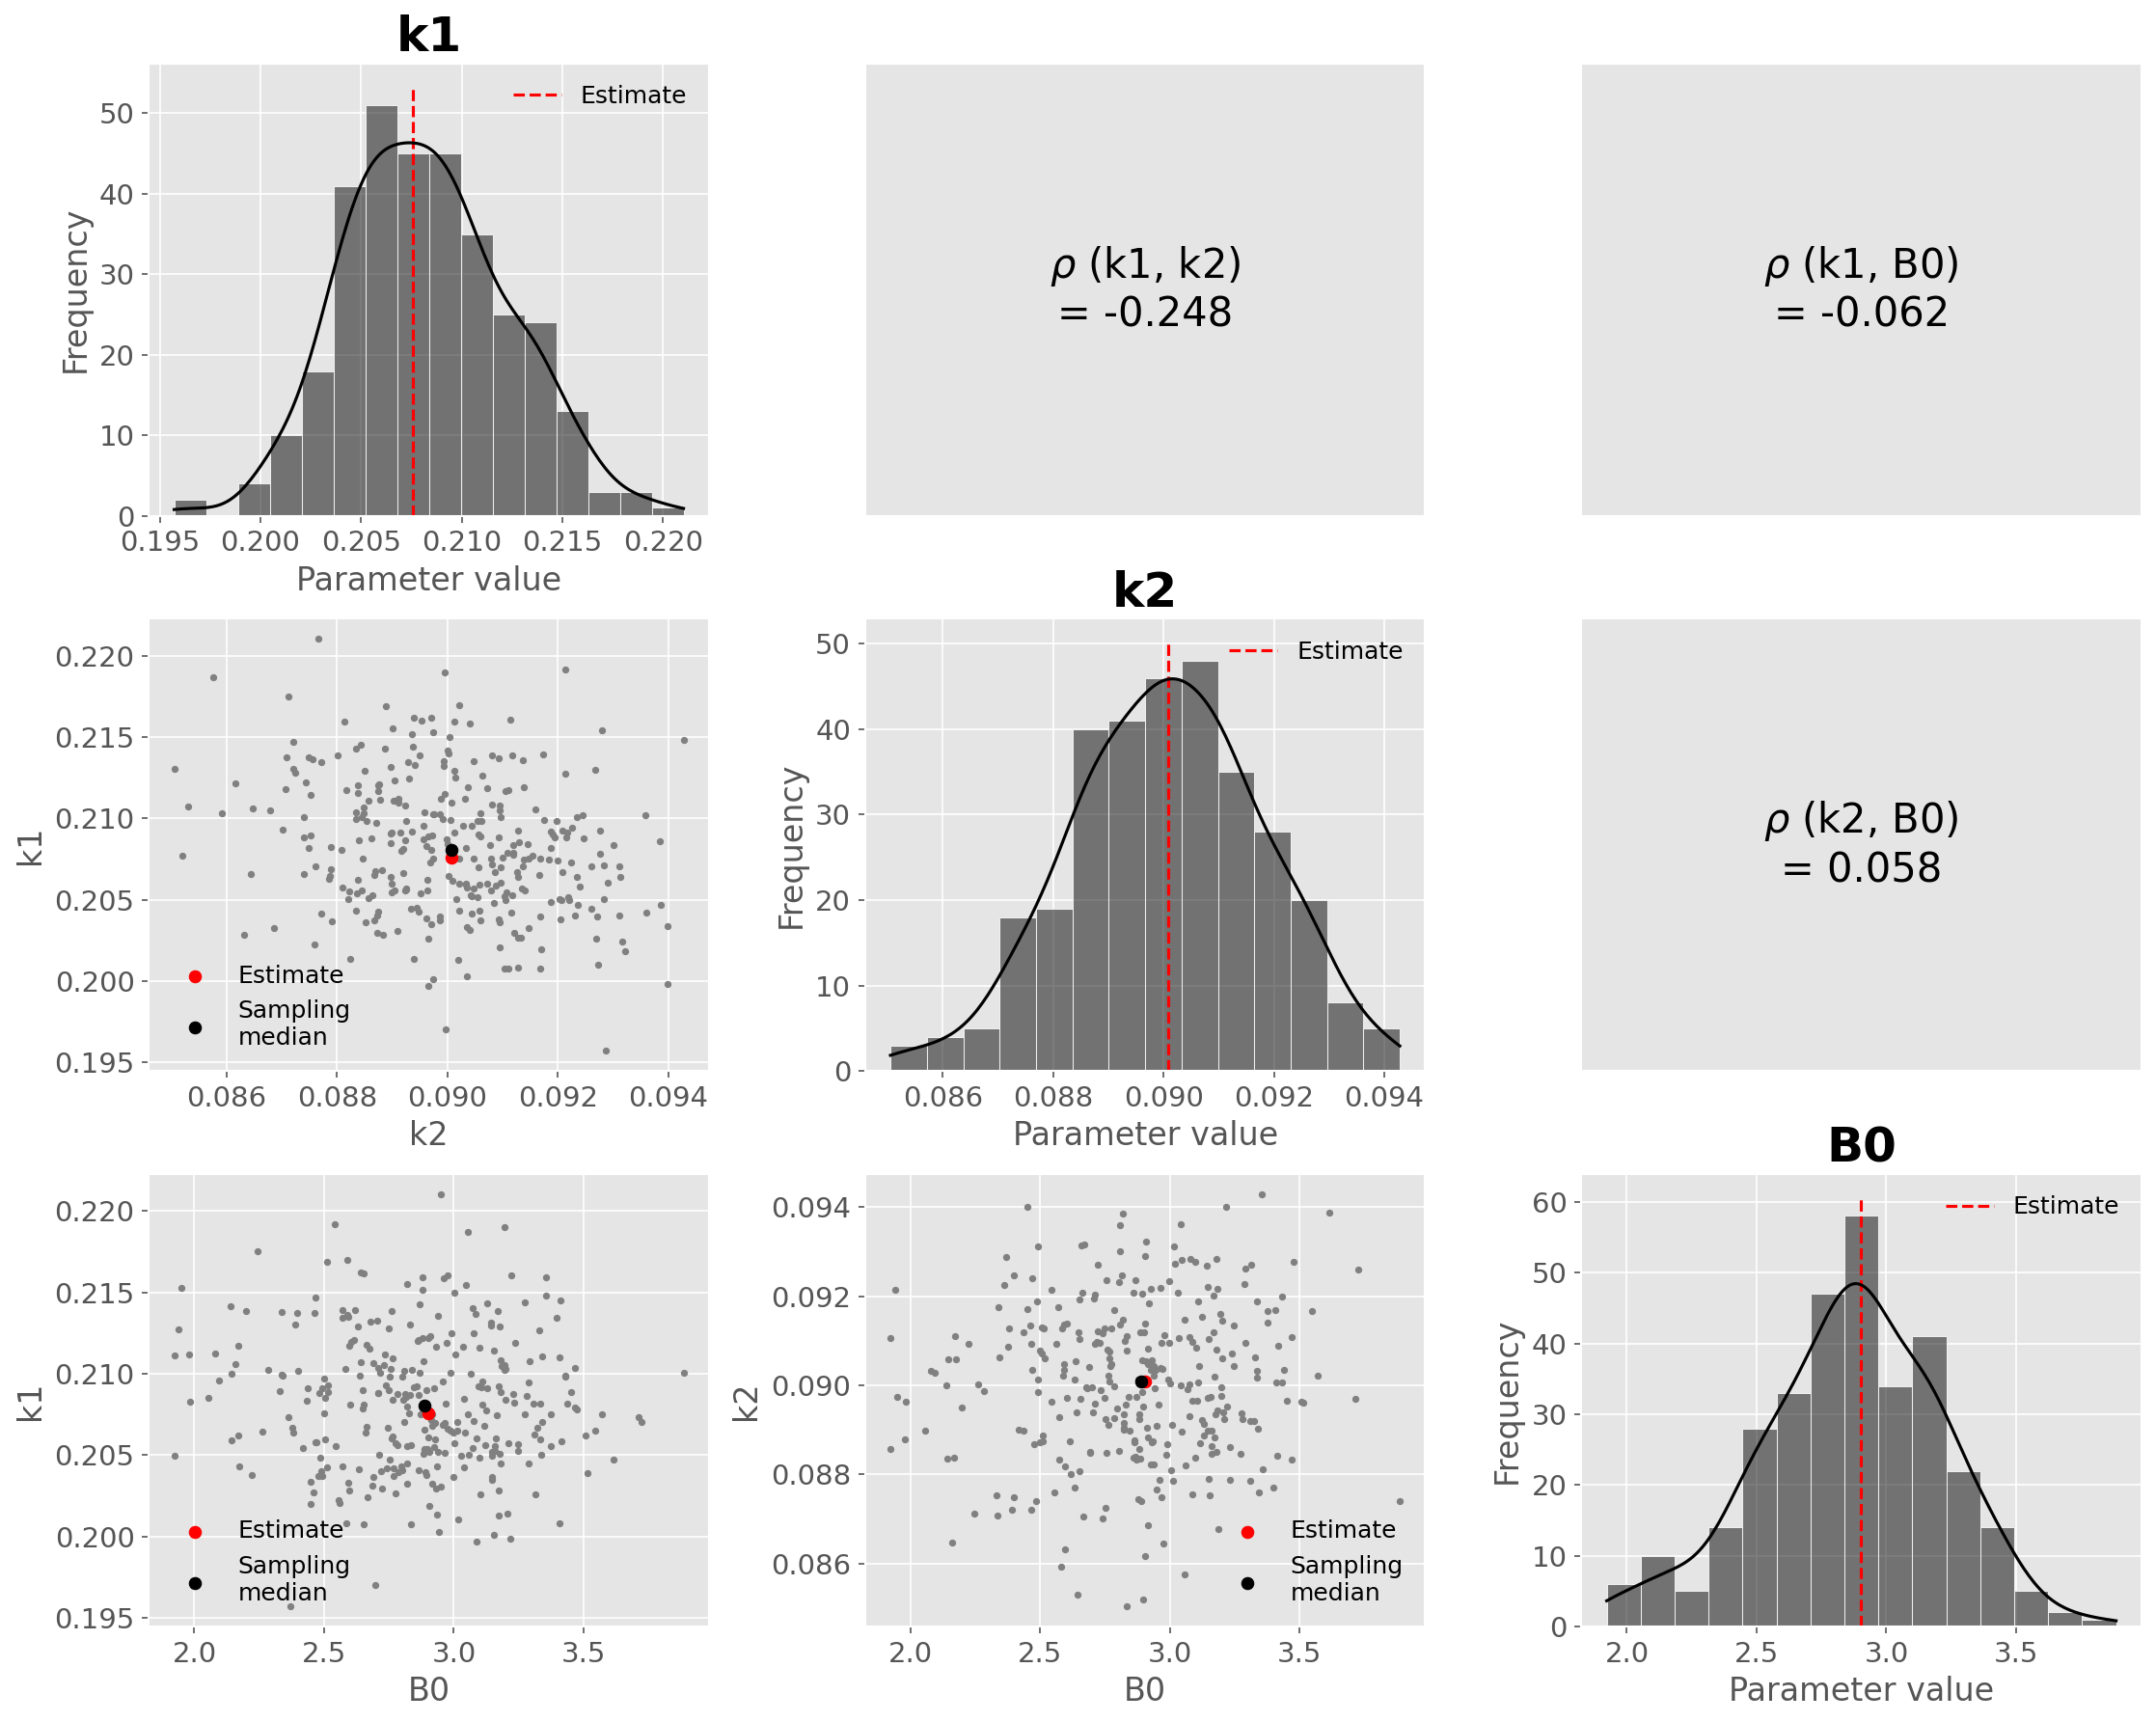

In [33]:
rhat, ess = hopsy.rhat(states), hopsy.ess(states, relative=True)
thinning = int(np.ceil(np.max(1./ess)))

print(rhat, ess)

est_mc = dict([(key, states[:,::thinning,i].flatten().tolist()) for i, key in enumerate(unknowns)])

_ = Visualization.compare_estimates_many(
    parameter_collections=est_mc, 
    measurements=data,
    caretaker=caretaker, 
    truth=simulation,
)

_ = Visualization.show_parameter_distributions(est_mc, show_corr_coeffs=True, estimates=est)

## 3. 13C Metabolic Flux Analysis

## 4. Bioprocess & 13C Models Combined